# Zillow Project

This project's goal is to analyze the zillow data, and create a model to predict house prices. To do this, I will use the CodeUp's Zillow database. I will acquire the data using a SQL query, and then using Python I will refine the data, explore it, and create some models. The target variable is the house price so I will be using some regression models to calculate a continuous variable.

## Goals:

* Acquire zillow data

* Prepare zillow data

* Explore data to find driving factors influencing house prices

    * What features have the most influence on price?
    * What features have the least influence?
    * How is the data distributed?
    <br/><br/>
* Create models, including a baseline model, to predict house prices  

* Analyze results

* Think about what could be improved, or what could be done differently to achieve better results. 

### Imports

In [1]:
import acquire as ac  # Contains necessary acquire functions
import prepare as prep  # Contains necessary functions to prepare data
import evaluate as ev  # Contains functions to evaluate models and statistical tests

import seaborn as sns  # Used in creating visuals and plots
import matplotlib.pyplot as plt  # Used in creating visuals and plots
from scipy import stats  # For stats testing.

import pandas as pd
import numpy as np

# For modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Acquisition

The first step is to acquire the necessary data for the project. For this, I will use my acquire function from my acquire.py file.

In [2]:
zil = ac.zillow_data(True)  # Uses function in acquire file to either load local .csv file or SQL query it
zil.head(3)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,poolcnt,garagecarcnt,fireplacecnt,fips,yearbuilt,lotsizesquarefeet
0,0.0,0.0,NaN,27516.0,NaN,NaN,NaN,6037.0,NaN,4083.0
1,0.0,0.0,NaN,10.0,NaN,NaN,NaN,6037.0,NaN,11975.0
2,0.0,0.0,NaN,10.0,NaN,NaN,NaN,6037.0,NaN,9403.0


This function will pul all single family properties with a transaction in 2017. It will not pull all features, it will only select certain features. To decide which features, I explored the data a little and grabbed only information that seemed relevant, and contained enough data (not too many nulls).

## Preparation

Now, it is time to prepare the data for exploration. In this step, data will be cleaned up so it is easier to explore on and also so it later on can be modeled.

This will require:

* Handling null values
* Renaming columns
* Binning data
* Handling outliers

In [3]:
zil = prep.prep_zillow(mvp=False, df=zil)  # prep_zillow prepares all of the data using my function in prepare.py
zil.head(3)

,bedrooms,bathrooms,sq_ft,price,pools,garages,fireplaces,fips,year,lot_sq_ft
4,4,2.0,3633.0,296425.0,0,0,0,Los Angeles County,2005,9826.0
7,3,2.0,2077.0,646760.0,0,0,0,Los Angeles County,1926,6490.0
11,0,0.0,1200.0,5328.0,0,0,0,Los Angeles County,1972,4054.0


Changes to data:

* Pools, garages, and fireplaces nulls were imputed as 0
* fips codes were converted to actual county names
* 350 rows of nulls dropped
* bathrooms, bedrooms, sq_ft, and lot_sq_ft were capped off, the top 0-5% of data was either binned or removed.

## Exploration

Now, I will begin exploring the data. In this step, the goal is to uncover patterns, relationships, correlations, or any useful information that may help me better understand what features can affect the price of a house.

The first thing to to is split my data. Exploration should be done ONLY ON TRAIN!

In [4]:
train, val, test = prep.train_val_test(zil)  # Split the data into 3 groups

train.shape, val.shape, test.shape  # Check to ensure data has correct shape

((36051, 10), (7725, 10), (7726, 10))

### How does the number of bedrooms affect the price of a house?

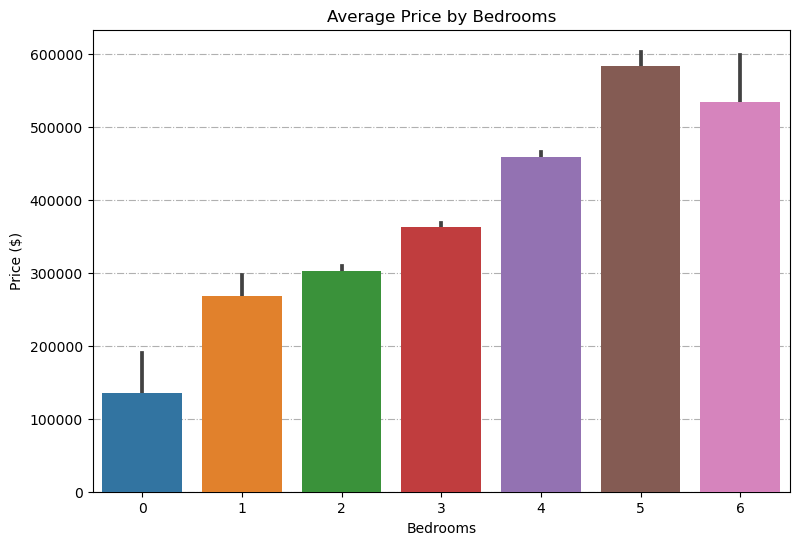

In [16]:
plt.figure(figsize=(9,6))  # Adjust figure size
sns.barplot(train, x='bedrooms', y='price', zorder=4)  # Input plot type and data
plt.grid(linestyle='-.', axis='y')  # Add grid line for better visualization
plt.title('Average Price by Bedrooms')  # Title for graph
plt.xlabel('Bedrooms')  # X label
plt.ylabel('Price ($)')  # Y label
plt.show()  # Cleanly plot the graph

There is a general trend showing an increase in house price with the number of bedrooms. At 5 bathrooms the prices seem to peak and then drop after that. I will run a statistics test to see if there is a statistical difference between the max and min number of bedrooms and average home price.

In [6]:
average = zil.price.mean()  # Average home price, of ALL houses
six_bed = zil[zil.bedrooms >= 6].price  # Home prices of 6 bedroom houses
one_bed = zil[zil.bedrooms == 1].price  # Home prices of 1 bedroom houses

Using a t-test, I will determine if there is a statistically significant relationship between these features. Now that I have isolated each sample, I can perform a one sample t-test

In [7]:
t, p = stats.ttest_1samp(six_bed, average)  # Performing statistics test. One-sample, One-tail, T-test
ev.check_ttest(t, p, tails=1)  # Evaluate test results using function in evaluate.py

There is a signifcant result. P-value was 0.0.
T-value was greater than 0. With a value of 6.08.


In [8]:
t, p = stats.ttest_1samp(one_bed, average)  # Performing statistics test. One-sample, One-tail, T-test
ev.check_ttest(t, p, tails=1)  # Evaluate test results using function in evaluate.py

There is a signifcant result. P-value was 0.0.
T-value was less than 0. With a value of -10.56.


Conclusion: The number of bedrooms has a positive relationship with the house prices. As the number of bedrooms increases, house prices do as well. Houses with 6 bedrooms have a much higher average cost than the average house and houses with one bedroom have a much lower average cost than the average house.

### How does the number of bathrooms affect house prices?

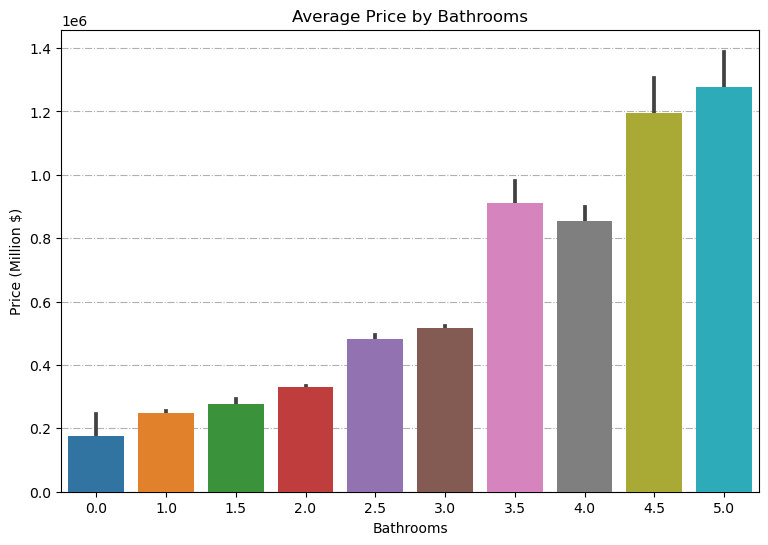

In [18]:
plt.figure(figsize=(9,6))  # Adjust figure size
sns.barplot(train, x='bathrooms', y='price', zorder=4)  # Input plot type and data
plt.title('Average Price by Bathrooms')  # Title for graph
plt.xlabel('Bathrooms')  # X label
plt.ylabel('Price (Million $)')  # Y label
plt.grid(linestyle='-.', axis='y')  # Add grid line for better visualization
plt.show()  # Cleanly plot the graph

Similar to bedrooms, there is a general increase in price as the number of bathrooms in a house increases. This is indicative of a postivie relationship between bathrooms and house prices.

Conclusion: There appears to be a very similar relationship between bathrooms and price to the observed relationship between bedrooms and price. As the number of bathrooms increase, so do the prices of houses.

### How does the square footage of house affect the price?

For this plot, I will remove the top 4.45% most expensive houses, because they will cause the graph to look very flat and poorly depict the data.

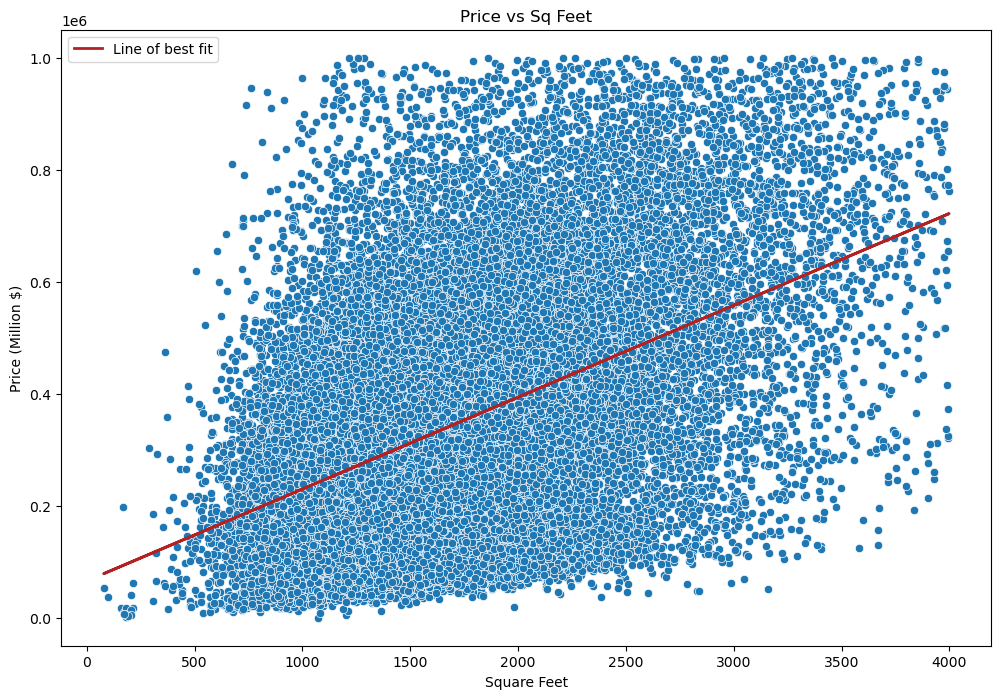

In [22]:
price_filter = train[train.price < 1_000_000]  # Remove the most expensive houses for a better visualization.

plt.figure(figsize=(12,8)) # Adjust figure size
sns.scatterplot(data=price_filter, x='sq_ft', y='price')  # Create plot
plt.title('Price vs Sq Feet')  # Title for graph
plt.xlabel('Square Feet')  # X label
plt.ylabel('Price (Million $)')  # Y label

# Line of best fit
a, b = np.polyfit(price_filter.sq_ft, price_filter.price, 1)
plt.plot(price_filter.sq_ft, a*price_filter.sq_ft+b, color='firebrick', linewidth=2, label='Line of best fit') 

plt.legend()
plt.show()  # Cleanly plot the graph

NOTE: THIS IS ONLY THE BOTTOM 95.55% OF HOUSES BY PRICE. THIS DOES NOT INCLUDE 100% OF ALL DATA.

Although the data is very spread out. There seems to be a trend between the two features. As house square footage increases, the house prices seem to increase as well. I can be sure of this correlation by performing a statistical test.

In [32]:
r, p = stats.pearsonr(train.sq_ft, train.price)  # Statistical test to check lot_sq_ft against house prices
ev.check_pearson(r,p)  # Evaluating test results

There is a moderate positive correlation. R-value was 0.495.
There is a signifcant result. P-value was 0.0.


Conclusion: There is a moderate correlation between house square footage and house price. As the size of the house increases the prices of a house tend to increase as well.

### Does the size of the lot have any effect on value of a house?

For this plot, I will once again remove the top 4.45% most expensive houses, because they will cause the graph to look very flat and poorly depict the data.

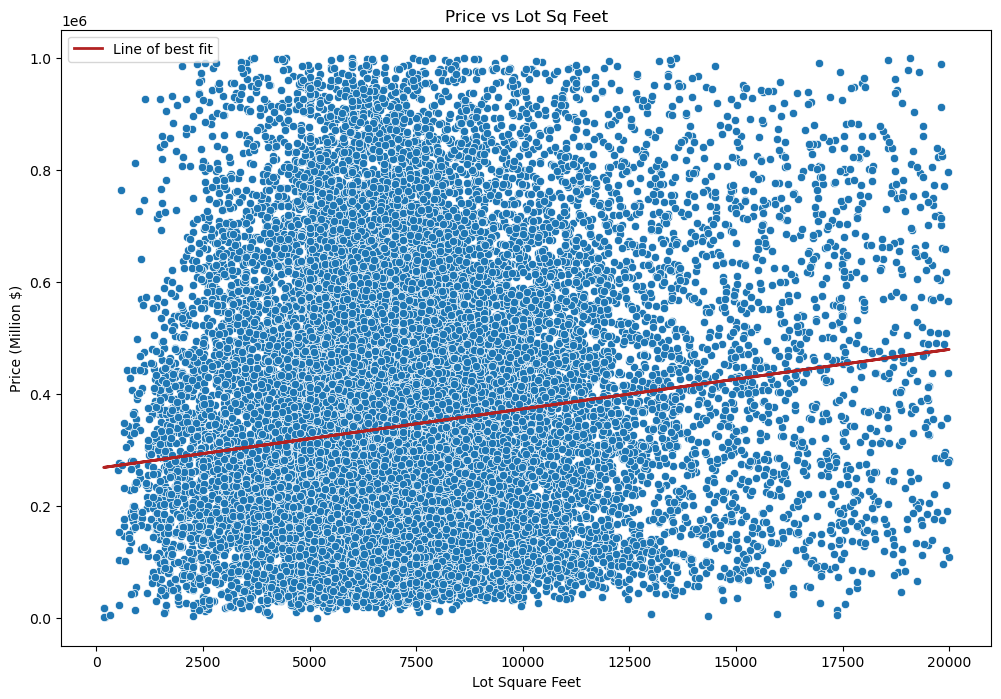

In [29]:
plt.figure(figsize=(12,8)) # Adjust figure size
sns.scatterplot(data=price_filter, x='lot_sq_ft', y='price')  # Create plot
plt.title('Price vs Lot Sq Feet')  # Title for graph
plt.xlabel('Lot Square Feet')  # X label
plt.ylabel('Price (Million $)')  # Y label

# Line of best fit
a, b = np.polyfit(price_filter.lot_sq_ft, price_filter.price, 1)
plt.plot(price_filter.lot_sq_ft, a*price_filter.lot_sq_ft+b, color='firebrick', linewidth=2, label='Line of best fit') 

plt.legend()
plt.show()  # Cleanly plot the graph

It is much less clear this time if there is any sort of correlation between the two features. To determine this, I will run another statistical test.

In [33]:
r, p = stats.pearsonr(train.lot_sq_ft, train.price)  # Statistical test to check lot_sq_ft against house prices
ev.check_pearson(r,p)  # Evaluating test results

There is a very slight positive correlation. R-value was 0.148.
There is a signifcant result. P-value was 0.0.


Coclusion: The size of the lot is very slightly correlated with price. The house square footage itself seems to be much more important than the size of the lot.

### Exploration Conclusions:

House prices seem to increase as they become bigger and have more amenities. Houses with more bedrooms and bathrooms average higher prices than houses with less bathrooms and bedrooms. The size of a house, in sq ft, has a moderate postive correlation with the price of the house, and the lot size has only a slight positive correlation indicating that it is not as impactful as the house size. It is expected that bigger houses with more rooms, size, and land will cost more than those with less rooms, size, and land.

## Modeling

Now, it is time to prepare the data for modeling and then create models to predict house prices.

The first step is to split and scale the data. For this, I will use my acquire and prepare function and then my scale function to create my scaled, train, val, test dataframes.

In [40]:
zil = ac.zillow_data(True)
zil = prep.prep_zillow(mvp=False, df=zil)

train, val, test = prep.scale(zil)

train.shape, val.shape, test.shape

((36051, 10), (7725, 10), (7726, 10))

In [ ]:
NEx

In [ ]:
train = pd.get_dummies(train, columns=['fips'])
val = pd.get_dummies(val, columns=['fips'])
test = pd.get_dummies(test, columns=['fips'])

## Conclusion